## Entity Matching Pipeline with rule based matching 

Notebook showing the implementation of an EM pipeline with rule-based matching.
Attribute based blocking is done, along with three matching rules on the basis of features obtained from the similarity values of the attributes

## Dataset exploration 
After going through multiple datasets like movies.csv; citations.csv etc., we chose the music dataset. 
In other datasets, we had issues like inaccessibility, same attributes not being present across the two datasets etc. 
The two music datasets have similar attributes across them. Attributes like Genre etc. can also be used as sensitive attributes.
The labeled dataset of size 539 was also available for music datasets for evaluation purpose.

In [65]:
# Importing the required libraries
import sys
import py_entitymatching as em
import pandas as pd
import os

In [66]:
# Load csv files as dataframes and set the key attribute in the dataframe
path_A = 'music1.csv'
path_B = 'music2.csv'
A = em.read_csv_metadata(path_A, key='Sno')
B = em.read_csv_metadata(path_B, key='Sno')

Metadata file is not present in the given path; proceeding to read the csv file.
Metadata file is not present in the given path; proceeding to read the csv file.


In [67]:
# Display number of tuples in the datasets
print('Number of tuples in A: ' + str(len(A)))
print('Number of tuples in B: ' + str(len(B)))
print('Number of tuples in A X B (i.e the cartesian product): ' + str(len(A)*len(B)))

Number of tuples in A: 6907
Number of tuples in B: 55923
Number of tuples in A X B (i.e the cartesian product): 386260161


In [68]:
# Displaying first two entries from the first music dataset
A.head(2)

,Sno,Album_Name,Album_Price,Artist_Name,CopyRight,Customer_Rating,Genre,Price,Released,Song_Name,Time,Group
0,1,Welcome to Cam Country - EP,$4.26,Cam,2015 Sony Music Entertainment,4.72396,"Country,Music,Contemporary Country,Honky Tonk",$0.99,31-Mar-15,Runaway Train,3:01,Country
1,2,Me 4 U,$9.99,Omi,"2015 Ultra Records, LLC under exclusive license to Columbia Records, a Division of Sony Music E...",3.38158,"Pop/Rock,Music,Pop,Dance,R&B/Soul",Album Only,NaN,Track 14,3:41,Pop


In [69]:
# Displaying first two entries from the second music dataset
B.head(2)

,Sno,Album_Name,Artist_Name,Song_Name,Price,Time,Released,Label,Copyright,Genre,Group
0,1,! (Volume 2) [Explicit],Rusko,Saxophone Stomp [Explicit],$1.29,3:20,"September 16, 2014",Decca International,(C) 2014 FMLY Under Exclusive License To Universal Music Canada Inc.,"Dance & Electronic,Dubstep",Dance
1,2,! (Volume 2) [Explicit],Rusko,I Wanna Mingle [feat. Pusher],$1.29,2:36,"September 16, 2014",Decca International,(C) 2014 FMLY Under Exclusive License To Universal Music Canada Inc.,"Dance & Electronic,Dubstep",Dance


In [70]:
# Display the keys of the input tables
print(em.get_key(A), em.get_key(B))
# If the tables are large we can downsample the tables like this
A1, B1 = em.down_sample(A, B, 1000, 1, show_progress=False)
print("Lengths after downsampling-")
print(len(A1), len(B1))

Sno Sno
Lengths after downsampling-
556 1000


Blocking

In [71]:
# Create attribute equivalence blocker
ab = em.AttrEquivalenceBlocker()

# Block using artist_name attribute
C = ab.block_tables(A1, B1, "Artist_Name","Artist_Name",
                    l_output_attrs=["Sno", "Album_Name", "Artist_Name", "CopyRight", "Released", "Song_Name" ,"Time"], 
                    r_output_attrs=["Sno", "Album_Name", "Artist_Name", "Copyright", "Released", "Song_Name", "Time"]
                    )

In [72]:
# Printing length of candidate set
len(C)

1276

Matching

In [73]:
# Sample candidate set
# S = em.sample_table(C, 538)

In [74]:
# Label S
# G = em.label_table(S, 'label')

In [75]:
# Load the pre-labeled data
path_G = 'music_labeled_data.csv'
G = em.read_csv_metadata(path_G, 
                         key='_id',
                         ltable=A, rtable=B, 
                         fk_ltable='ltable.Sno', fk_rtable='rtable.Sno')
print(len(G))

Metadata file is not present in the given path; proceeding to read the csv file.


539


In [76]:
# Initializing the rule based matcher
brm = em.BooleanRuleMatcher()

In [77]:
# Generate features
feature_table = em.get_features_for_matching(A, B, validate_inferred_attr_types=False)

In [78]:
# Listing the names of the features generated
feature_table['feature_name']

0                                     Sno_Sno_exm
1                                     Sno_Sno_anm
2                                Sno_Sno_lev_dist
3                                 Sno_Sno_lev_sim
4           Album_Name_Album_Name_jac_qgm_3_qgm_3
5       Album_Name_Album_Name_cos_dlm_dc0_dlm_dc0
6       Album_Name_Album_Name_jac_dlm_dc0_dlm_dc0
7                       Album_Name_Album_Name_mel
8                  Album_Name_Album_Name_lev_dist
9                   Album_Name_Album_Name_lev_sim
10                      Album_Name_Album_Name_nmw
11                       Album_Name_Album_Name_sw
12        Artist_Name_Artist_Name_jac_qgm_3_qgm_3
13    Artist_Name_Artist_Name_cos_dlm_dc0_dlm_dc0
14    Artist_Name_Artist_Name_jac_dlm_dc0_dlm_dc0
15                    Artist_Name_Artist_Name_mel
16               Artist_Name_Artist_Name_lev_dist
17                Artist_Name_Artist_Name_lev_sim
18                    Artist_Name_Artist_Name_nmw
19                     Artist_Name_Artist_Name_sw


In [79]:
# Since feature related to time is not present due to the difference in data types, we create the time feature manually.
# Creating function for checking if the two timevalues are equal or not.
def time_feature(ltuple, rtuple):
    p1 = ltuple.Time
    p2 = rtuple.Time
    if p1 == p2:
        return 1.0
    else:
        return 0.0

# Add feature to the feature table
em.add_blackbox_feature(feature_table, 'time_time_feature', time_feature)

True

In [80]:
# Add two rules to the rule-based matcher

# The first rule compares the album names
brm.add_rule(['Album_Name_Album_Name_lev_sim(ltuple, rtuple) > 0.8'], feature_table)
# This second rule compares the genres
brm.add_rule(['Genre_Genre_lev_sim(ltuple, rtuple) > 0.8'], feature_table)
# This third rule compares the times
brm.add_rule(['time_time_feature(ltuple, rtuple) == 1'],feature_table)
brm.get_rule_names()

odict_keys(['_rule_0', '_rule_1', '_rule_2'])

In [81]:
brm.predict(G, target_attr='pred_label', append=True)
G.head(5)

,Unnamed: 0,_id,ltable.Sno,rtable.Sno,ltable.Album_Name,ltable.Artist_Name,ltable.CopyRight,ltable.Released,ltable.Song_Name,ltable.Time,rtable.Album_Name,rtable.Artist_Name,rtable.CopyRight,rtable.Released,rtable.Song_Name,rtable.Time,label,lgenre,rgenre,pred_label
0,916,916,111,53124,vhs,x ambassadors,2015 kidinakorner/interscope records,30-Jun-15,vhs outro (interlude),1:25,vhs [explicit],x ambassadors,(c) 2015 kidinakorner/interscope records,"June 30, 2015",vhs outro (interlude) [explicit],1:25,1,Alternative,Alternative,1
1,1053,1053,148,50767,title (deluxe),meghan trainor,"2014, 2015 epic records, a division of sony music entertainment",9-Jan-15,credit,2:51,title (deluxe),meghan trainor,"2011 what a music ltd, licence exclusive parlophone music france","January 9, 2015",credit,2:51,1,Pop,Pop,1
2,1290,1290,206,41214,slow down (remixes),selena gomez,"2013 hollywood records, inc.",20-Aug-13,slow down (smash mode remix),5:21,slow down remixes,selena gomez,"(c) 2013 hollywood records, inc.","August 20, 2013",slow down (smash mode remix),5:21,1,Dance,Dance,1
3,1424,1424,211,19812,slow down (reggae remixes) - single,selena gomez,"2013 hollywood records, inc.",20-Aug-13,slow down (sure shot rockers reggae dub remix),3:15,good for you (remixes),selena gomez,(c) 2015 interscope records,"September 4, 2015",good for you (yellow claw & cesqeaux remix) [feat. a$ap rocky],3:01,0,Other,Pop,0
4,1706,1706,250,53111,vhs,x ambassadors,2015 kidinakorner/interscope records,30-Jun-15,vhs outro (interlude),1:25,vhs [explicit],x ambassadors,(c) 2015 kidinakorner/interscope records,"June 30, 2015",first show (interlude),0:11,0,Alternative,Alternative,0


In [82]:
# Evaluate the predictions
eval_result = em.eval_matches(G, 'label', 'pred_label')
em.print_eval_summary(eval_result)

Precision : 71.95% (118/164)
Recall : 89.39% (118/132)
F1 : 79.73%
False positives : 46 (out of 164 positive predictions)
False negatives : 14 (out of 375 negative predictions)


# For involving fairness constraints, we take Genre as the sensitive attributes
#### The following distribution of distinct categories was obtained for the two datasets-->
#Music 1 : {'Pop': 1758, 'Hip-Hop': 685, 'Rock': 515, 'Dance': 952, 'Country': 1367, 
'Electronic': 211, 'Alternative': 484, 'Soundtrack': 397, 'Other': 538}

#Music 2 : {'Pop': 7130, 'Rap & Hip-Hop': 3400, 'Rock': 3248, 'Dance': 8274, 'Country': 8317, 'Electronic': 4019, 'Alternative': 4806, 'Soundtrack': 3594, 'Other': 13135}

Rap & Hip-Hop converted to Hip-Hop in music2 for consistency.

## There were mamy distinct categories in the dataset, they have been clubbed into umbrella categories as shown above.


In [85]:
#In case of matching and different groups in music1 and music2, group of music1 is taken (15 such cases were there)
NG = G.to_numpy()

mgs = list()
lst = ['Pop','Hip-Hop','Rock','Dance','Country','Electronic','Alternative','Soundtrack','Other']
for z in lst:
    cnt,pos,neg,fp,fn= [0,0,0,0,0]
    for x in NG:
        if(x[-2]== z):
            cnt+=1
            if(x[-1]==1 and x[-4]==1):
                pos+=1
            elif(x[-1]==1 and x[-4]==0):
                fp+=1
            elif(x[-1]==0 and x[-4]==1):
                fn+=1
            else:
                neg+=1
    print('Total count of '+z+' = '+str(cnt))
    print('Positive = ',pos)
    print('Negative = ',neg)
    print('False Pos = ',fp)
    print('False Neg = ',fn)
    mg_ = (fp+fn)/cnt
    print('Mg = ', mg_)
    mgs.append(mg_)
    print('\n\n\n')


Total count of Pop = 85
Positive =  26
Negative =  50
False Pos =  5
False Neg =  4
Mg =  0.10588235294117647




Total count of Hip-Hop = 121
Positive =  16
Negative =  100
False Pos =  1
False Neg =  4
Mg =  0.04132231404958678




Total count of Rock = 34
Positive =  7
Negative =  27
False Pos =  0
False Neg =  0
Mg =  0.0




Total count of Dance = 156
Positive =  17
Negative =  110
False Pos =  28
False Neg =  1
Mg =  0.1858974358974359




Total count of Country = 57
Positive =  36
Negative =  13
False Pos =  6
False Neg =  2
Mg =  0.14035087719298245




Total count of Electronic = 27
Positive =  3
Negative =  20
False Pos =  4
False Neg =  0
Mg =  0.14814814814814814




Total count of Alternative = 27
Positive =  8
Negative =  17
False Pos =  0
False Neg =  2
Mg =  0.07407407407407407




Total count of Soundtrack = 4
Positive =  1
Negative =  1
False Pos =  2
False Neg =  0
Mg =  0.5




Total count of Other = 28
Positive =  4
Negative =  23
False Pos =  0
False Neg =  1
Mg =

In [92]:
gmu = sum(mgs)/len(mgs)
print('GMU = ',gmu)
biases=list()
for i,x in enumerate(lst):
    bias = (gmu - mgs[i])/gmu
    biases.append(bias)
    print('Total bias in '+x+' = '+str(bias))

GMU =  0.13682105422418775
Total bias in Pop = 0.22612529525110045
Total bias in Hip-Hop = 0.6979827828114946
Total bias in Rock = 1.0
Total bias in Dance = -0.35869027578777596
Total bias in Country = -0.025798828906923327
Total bias in Electronic = -0.08278765273508573
Total bias in Alternative = 0.45860617363245715
Total bias in Soundtrack = -2.6544083279809145
Total bias in Other = 0.738970833715649
End


#### "If G’s mismatches are equal to the average number of mismatches of all groups, then its bias is equal to zero. On the other hand, if the mismatches of G are more than the average, then bias gets a negative value, and, in this case, we consider that the method examined is negatively biased against G. 

#### Finally, when the average number of mismatches is greater than that of G, then we assume that the method is biased in favor ofG. Values close to 0 indicate low bias, while as the absolute value of bias increases, this is an indication of increased bias, either positive or negative." - EDBT PAPER

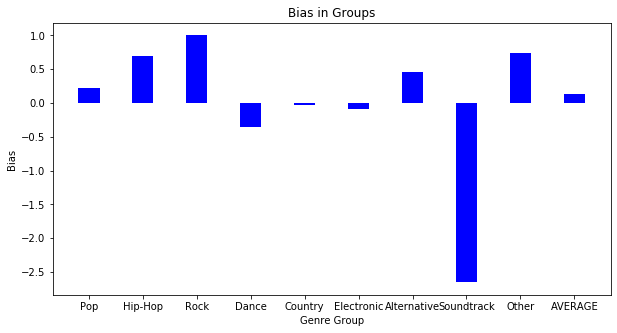

In [94]:
import numpy as np 
import matplotlib.pyplot as plt  
     
fig = plt.figure(figsize = (10, 5))

lst.append('AVERAGE')
biases.append(gmu)

plt.bar(lst, biases, color ='blue', width = 0.4) 
  
plt.xlabel("Genre Group") 
plt.ylabel("Bias") 
plt.title("Bias in Groups") 
plt.show() 